# EP da P1 - PSI3471 (2024 - $1^o$ semestre)

| Nome Completo | Thiago da Rocha Calomino Gonçalves |
|---------------|------------------------------------|
| NUSP          | 12554647                           |
| E-mail        | thcalomino@usp.br                  |


# Enunciado

Link: [Enunciado do EP-P1](https://psi3471.github.io/ex_avaliacao.html)

Na parte prática da avaliação, você vai trabalhar com um projeto de uma aplicação com redes neurais para a área de saúde. O objetivo é obter um modelo de predição de uma doença cardíaca baseado em dados com características extraídas de exames clínicos laboratoriais.


# Instalações das dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix

import requests
from PIL import Image
from io import BytesIO

# Importação dos dados

In [2]:
filepath_data_train = "/content/data_train.csv"
filepath_data_test = "/content/data_test.csv"

data_train = pd.read_csv(filepath_data_train).drop(columns=["Unnamed: 0"])
data_test = pd.read_csv(filepath_data_test).drop(columns=["Unnamed: 0"])

data_train.shape

(800, 14)

In [3]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,0.0
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,0.0
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,0.0
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,0.0
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,0.0


In [4]:
data_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,67.0,1.0,0.0,120.0,229.0,0.0,0.0,129.0,1.0,2.6,1.0,2.0,3.0,0.0
1,63.0,1.0,3.0,145.0,233.0,1.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
2,63.0,0.0,0.0,124.0,197.0,0.0,1.0,136.0,1.0,0.0,1.0,0.0,2.0,0.0
3,52.0,1.0,0.0,112.0,230.0,0.0,1.0,160.0,0.0,0.0,2.0,1.0,2.0,0.0
4,58.0,0.0,0.0,130.0,197.0,0.0,1.0,131.0,0.0,0.6,1.0,0.0,2.0,1.0


In [5]:
data_train.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,-0.094022,-0.099357,0.269698,0.248505,0.131297,-0.132380,-0.402270,0.089505,0.209740,-0.167409,0.269253,0.084769,-0.242654
1,-0.094022,1.000000,-0.031581,-0.070932,-0.201504,0.034667,-0.065690,-0.063543,0.129679,0.097250,-0.030315,0.133791,0.190763,-0.295186
2,-0.099357,-0.031581,1.000000,0.008988,-0.114006,0.064124,0.065333,0.318026,-0.401287,-0.194476,0.131717,-0.193460,-0.157324,0.460949
3,0.269698,-0.070932,0.008988,1.000000,0.107966,0.193433,-0.133562,-0.058469,0.080269,0.216787,-0.158742,0.118286,0.083212,-0.149633
4,0.248505,-0.201504,-0.114006,0.107966,1.000000,0.025899,-0.147630,-0.059015,0.105519,0.076283,-0.043198,0.063187,0.143590,-0.110328
5,0.131297,0.034667,0.064124,0.193433,0.025899,1.000000,-0.112045,-0.039968,0.082361,0.024241,-0.077003,0.144102,-0.035697,-0.062017
6,-0.132380,-0.065690,0.065333,-0.133562,-0.147630,-0.112045,1.000000,0.035885,-0.075024,-0.043988,0.089596,-0.068619,-0.042533,0.137448
7,-0.402270,-0.063543,0.318026,-0.058469,-0.059015,-0.039968,0.035885,1.000000,-0.381916,-0.368438,0.422303,-0.211019,-0.091469,0.439913
8,0.089505,0.129679,-0.401287,0.080269,0.105519,0.082361,-0.075024,-0.381916,1.000000,0.311806,-0.285161,0.113074,0.195970,-0.450152
9,0.209740,0.097250,-0.194476,0.216787,0.076283,0.024241,-0.043988,-0.368438,0.311806,1.000000,-0.566057,0.216514,0.219577,-0.446975


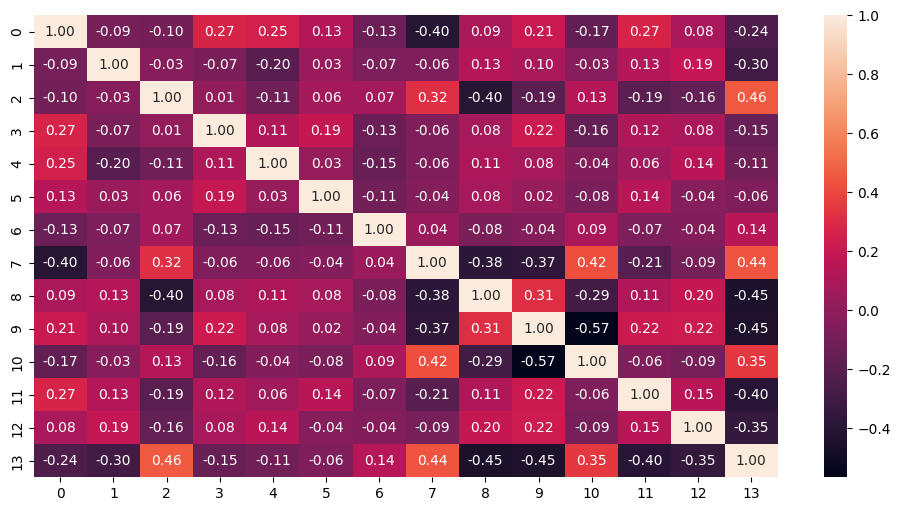

In [ ]:
# Heatmap da matriz de correlação do conjunto de dados de treinamento

plt.figure(figsize=(12,6))
sns.heatmap(data_train.corr(), annot=True, fmt='.2f')
plt.show()

# Implementação da rede

Para reprodução dos resultados mais verossímil fixamos seeds para o Numpy e o PyTorch. Este último adicionando ainda suporte a cálculos via CUDA usando a GPU.

Em seguida, definimos os hiperparâmetros para treinamento do modelo, tais como passo de adaptação, tamanho do mini-batch e o número de _epochs_.

In [ ]:
######### Configurações de seed e hiperparâmetros #########
# Fixando seeds para poder reproduzir os resultados
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

### Ajuste de hiperparâmetros

# passo de adaptação da rede
eta = 0.1/100

# Tamanho do mini-batch
Nb = 200

# Número de épocas
Ne = 10*1000



######### Modelo de neurônio para esta primeira implementação de rede neural #########
class Model(nn.Module):

    # Geralmente, os blocos da rede são definidos no método _init_()
    def __init__(self):
        # Necessário chamar _init_() da classe mãe
        super().__init__()

        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com 13 elementos, conectada a 100 neurônios na primeira camada oculta
            nn.Linear(13, 100),
            nn.Sigmoid(),

            # Saídas de 100 neurônios conectadas a 1 neurônio na segunda camada oculta
            nn.Linear(100, 1)
        )


    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output



######### Treinamento via GPU, função de perda e otimizador #########
# Configuração de treinamento do modelo via CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model().to(device=device)

# Função de perda
#loss_function = nn.BCEWithLogitsLoss()
loss_function = nn.MSELoss()

# Otimizador
#optimizer = torch.optim.SGD(model.parameters(), lr=eta)
optimizer = torch.optim.Adam(model.parameters(), lr=eta, betas=(0.9, 0.999))

## Treinamento do modelo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.2435545027256012 Val. Loss: 0.2621975541114807
Epoch: 100 Loss: 0.08957856148481369 Val. Loss: 0.37460917234420776
Epoch: 200 Loss: 0.0896226093173027 Val. Loss: 0.4043678343296051
Epoch: 300 Loss: 0.07829024642705917 Val. Loss: 0.4192149341106415
Epoch: 400 Loss: 0.06756340712308884 Val. Loss: 0.4260534644126892
Epoch: 500 Loss: 0.06585434824228287 Val. Loss: 0.43242552876472473
Epoch: 600 Loss: 0.045234475284814835 Val. Loss: 0.4349417984485626
Epoch: 700 Loss: 0.03965665027499199 Val. Loss: 0.44391074776649475
Epoch: 800 Loss: 0.04075879976153374 Val. Loss: 0.4500117301940918
Epoch: 900 Loss: 0.024436766281723976 Val. Loss: 0.45429527759552
Epoch: 1000 Loss: 0.03441654145717621 Val. Loss: 0.45686373114585876
Epoch: 1100 Loss: 0.028512971475720406 Val. Loss: 0.45583829283714294
Epoch: 1200 Loss: 0.02028963714838028 Val. Loss: 0.46313393115997314
Epoch: 1300 Loss: 0.01520449761301279 Val. Loss: 0.4686416983604431
Epoch: 1400 Loss: 0.025936555117368698 Val. Loss: 0.474

Text(0, 0.5, 'Loss')

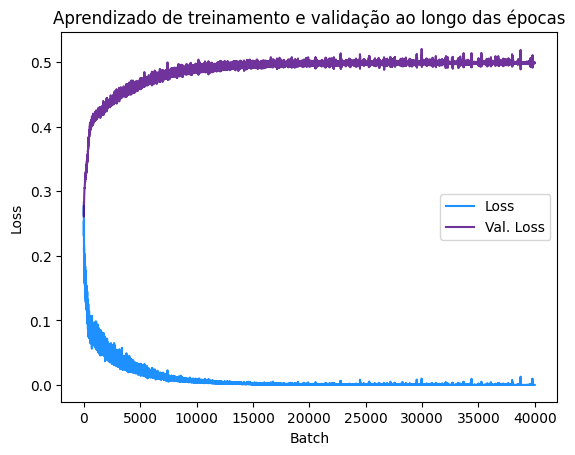

In [ ]:
# Converter as colunas do DataFrame em tensores
features = torch.tensor(data_train.iloc[:, :-1].values, dtype=torch.float32)
targets = torch.tensor(data_train.iloc[:, -1].values, dtype=torch.float32)

dataset = TensorDataset(features, targets)

train_loader = DataLoader(dataset, batch_size=Nb, shuffle=True)

X_val = torch.tensor(data_train.iloc[:, :-1].values, dtype=torch.float32).to(device=device)
d_val = torch.tensor(data_train.iloc[:, -1].values, dtype=torch.float32).to(device=device)

## ------- ##

# Lista usada para guardar o valor da função custo ao longo das iterações e validação ao longo das iterações
losses = []
val_losses = []

# Loop das épocas
for epoch in range(Ne):
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.to(device=device)

        # Necessário colocar o modelo em modo treinamento
        # na etapa de treinamento
        model.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        optimizer.zero_grad()

        # Calcula a saída
        y = model(X)

        # Reformula o tensor de destino (d) para corresponder à forma esperada
        d = d.view(-1, 1)  # Reformula para [tamanho do lote, 1]

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer.step()

        # Validação
        # Necessário colocar o modelo em modo de inferência (eval)
        # pois algumas camadas têm comportamento diferente para inferência,
        # por exemplo, o Dropout.
        model.eval()

        # Cálculo da saída e valor da função custo com os dados de validação
        # Nesse caso, não é necessário calcular gradientes, por isso é utilizado
        # o bloco with torch.no_grad():
        with torch.no_grad():
            y_val = model(X_val)
            val_loss = loss_function(y_val, d_val)

        # Armazena o valor da função custo de treinamento e validação
        losses.append(loss.item())
        val_losses.append(val_loss.item())

       # Mostra os valores da função custo de treinamento e validação
        # a cada 100 épocas
        if epoch % 100 == 0 and n == data_train.shape[0]//Nb - 1:
            print(f"Epoch: {epoch} Loss: {loss} Val. Loss: {val_loss}")


plt.figure()
plt.title("Aprendizado de treinamento e validação ao longo das épocas")
plt.plot(losses, color='dodgerblue')
plt.plot(val_losses, alpha=0.8, color ='indigo')
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")

## Inferência com teste

In [ ]:
# Converter as colunas do DataFrame em tensores
featuresTest = torch.tensor(data_test.iloc[:, :-1].values, dtype=torch.float32)
targetsTest = torch.tensor(data_test.iloc[:, -1].values, dtype=torch.float32)

datasetTest = TensorDataset(featuresTest, targetsTest)

test_loaderTest = DataLoader(datasetTest, batch_size=Nb, shuffle=False)


# Inicializar variáveis de contagem
total_samples = 0
correct_predictions = 0
saida = []

# Loop sobre os dados de teste
for n, (X, d) in enumerate(test_loaderTest):
    # Envia os dados para a GPU, caso ela exista
    X = X.to(device=device)
    d = d.to(device=device)

    # Coloca o modelo em modo de inferência
    model.eval()

    # Calcula a saída
    y = model(X)

    # Converte as probabilidades para rótulos binários (0 ou 1)
    predicted_labels = (y >= 0.5).float()

    # Atualiza a contagem de acertos
    total_samples += d.size(0)
    correct_predictions += (predicted_labels == d.unsqueeze(1)).sum().item()

    for y_saida in predicted_labels.numpy():
      saida.append(y_saida[0])

# Calcula a acurácia
accuracy = correct_predictions / total_samples
accuracy *= 100

# Printa a acurácia
print(f"Acurácia: {accuracy:.2f} %")

Acurácia: 100.00 %


Além da frequência de valores dos dados de testes e na predição dos dados de teste, temos o valor de F1-score

In [ ]:
# Frequência de valores no dataset de test:
unique, counts = np.unique(data_test.iloc[:, 8], return_counts=True)
print("Valor f")
print(np.asarray((unique, counts)).T)


# Frequência de valores na predição do dataset de test:
unique, counts = np.unique(np.array(saida), return_counts=True)
print("\n\nValor f")
print(np.asarray((unique, counts)).T)

## Confusion matrix
cm = confusion_matrix(data_test.iloc[:, 8].values, np.array(saida))
# Extrai os valores da matriz de confusão
verdadeiros_negativos, falsos_positivos, falsos_negativos, verdadeiros_positivos = cm.ravel()


# Cálculo de F1-Score
precision = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos)
recall = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)
f1_score = 2 * precision * recall / (precision + recall)

print(f"\n\nF1-Score = {f1_score}")

Valor f
[[  0. 147.]
 [  1.  78.]]


Valor f
[[  0. 115.]
 [  1. 110.]]


F1-Score = 0.18085106382978725


Classificação por Confusion Matrix

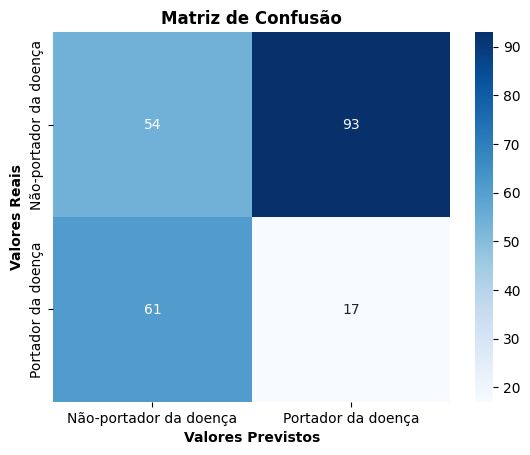


Verdadeiros negativos (VN): 54
Falsos positivos (FP): 93

Falsos negativos (FN): 61
Verdadeiros positivos (VP): 17



In [ ]:
classes = ['Não-portador da doença', 'Portador da doença']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Configurações do gráfico
plt.title('Matriz de Confusão', fontweight='bold')
plt.xlabel('Valores Previstos', fontweight='bold')

plt.ylabel('Valores Reais', fontweight='bold')

# Exibe o gráfico
plt.show()


print(f"""
Verdadeiros negativos (VN): {verdadeiros_negativos}
Falsos positivos (FP): {falsos_positivos}

Falsos negativos (FN): {falsos_negativos}
Verdadeiros positivos (VP): {verdadeiros_positivos}
""")


# Modelo de regressão logística

Definição dos hiperparâmetros e carregamento dos dados de treinamento deste modelo

In [ ]:
# Hiperparâmetros iguais aos do modelo de rede anterior

# Converter as colunas do DataFrame em tensores
features = torch.tensor(data_train.iloc[:, :-1].values, dtype=torch.float32)
targets = torch.tensor(data_train.iloc[:, -1].values, dtype=torch.float32)

dataset = TensorDataset(features, targets)

train_loader = DataLoader(dataset, batch_size=Nb, shuffle=True)

Classe para definição do neurônio do modelo de regressão logística

In [ ]:
# Definir a classe da rede
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [ ]:
# Configuração de execução via CUDA para treinamento do modelo de regressão logistica
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LogisticRegression = model.to(device=device)

## Treinamento do modelo de regressão logistica

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Loss: 0.05040634796023369 Val. Loss: 0.501237690448761
Epoch: 100 Loss: 2.3530332327936776e-05 Val. Loss: 0.4991817772388458
Epoch: 200 Loss: 8.42892040964216e-05 Val. Loss: 0.4997183680534363
Epoch: 300 Loss: 0.0002937234239652753 Val. Loss: 0.499482661485672
Epoch: 400 Loss: 0.0016975377220660448 Val. Loss: 0.5001756548881531
Epoch: 500 Loss: 0.0005932370549999177 Val. Loss: 0.49522021412849426
Epoch: 600 Loss: 0.0007308219210244715 Val. Loss: 0.4945090413093567
Epoch: 700 Loss: 5.2687963034259155e-05 Val. Loss: 0.498732328414917
Epoch: 800 Loss: 6.540840695379302e-05 Val. Loss: 0.49961644411087036
Epoch: 900 Loss: 0.0001119507069233805 Val. Loss: 0.4995412528514862
Epoch: 1000 Loss: 7.519236532971263e-05 Val. Loss: 0.4982774555683136
Epoch: 1100 Loss: 5.0911432481370866e-05 Val. Loss: 0.49800434708595276
Epoch: 1200 Loss: 0.00029983167769387364 Val. Loss: 0.4974040985107422
Epoch: 1300 Loss: 0.0007300471770577133 Val. Loss: 0.5021363496780396
Epoch: 1400 Loss: 0.00058387697

Text(0, 0.5, 'Loss')

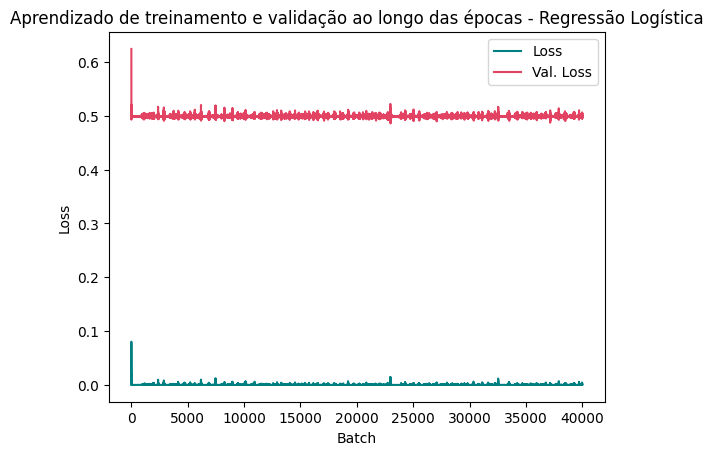

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(LogisticRegression.parameters(), lr=eta, betas=(0.9, 0.999))


# Lista usada para guardar o valor da função custo ao longo das iterações
losses = []
val_losses = []

# Loop das épocas
for epoch in range(Ne):
    # Loop dos mini batches - note que é usado o DataLoader para obter
    # os sinais de entrada e desejado, X e d
    for n, (X, d) in enumerate(train_loader):
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.to(device=device)

        # Necessário colocar o modelo em modo treinamento
        # na etapa de treinamento
        LogisticRegression.train()

        # Zera informações de gradientes: por padrão o PyTorch acumula os
        # gradientes a cada chamada de loss.backward(). Na maioria dos casos,
        # estamos interessados apenas no último valor dos gradientes
        LogisticRegression.zero_grad()

        # Calcula a saída
        y = LogisticRegression(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d.unsqueeze(1))

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo, de acordo com as regras
        # do otimizador escolhido
        optimizer.step()

        # Validação
        # Necessário colocar o modelo em modo de inferência (eval)
        # pois algumas camadas têm comportamento diferente para inferência,
        # por exemplo, o Dropout.
        LogisticRegression.eval()

        # Cálculo da saída e valor da função custo com os dados de validação
        # Nesse caso, não é necessário calcular gradientes, por isso é utilizado
        # o bloco with torch.no_grad():
        with torch.no_grad():
            y_val = LogisticRegression(X_val)
            val_loss = loss_function(y_val, d_val)


        # Armazena o valor da função custo
        losses.append(loss.item())
        val_losses.append(val_loss.item())

       # Mostra os valores da função custo de treinamento e validação
        # a cada 100 épocas
        if epoch % 100 == 0 and n == data_train.shape[0]//Nb - 1:
            print(f"Epoch: {epoch} Loss: {loss} Val. Loss: {val_loss}")

plt.figure()
plt.title("Aprendizado de treinamento e validação ao longo das épocas - Regressão Logística")
plt.plot(losses, color='teal')
plt.plot(val_losses, alpha=0.8, color ='crimson')
plt.legend(["Loss", "Val. Loss"])
plt.xlabel("Batch")
plt.ylabel("Loss")

## Inferência com teste

In [ ]:
# Converter as colunas do DataFrame em tensores
featuresTest = torch.tensor(data_test.iloc[:, :-1].values, dtype=torch.float32)
targetsTest = torch.tensor(data_test.iloc[:, -1].values, dtype=torch.float32)

datasetTest = TensorDataset(featuresTest, targetsTest)

test_loaderTest = DataLoader(datasetTest, batch_size=Nb, shuffle=False)

In [ ]:
# Inicializar variáveis de contagem
total_samples = 0
correct_predictions = 0
saida = []
predicted_labels = np.zeros_like(predicted_labels) # inicializando novamente

# Loop sobre os dados de teste
for n, (X, d) in enumerate(test_loaderTest):
    # Envia os dados para a GPU, caso ela exista
    X = X.to(device=device)
    d = d.to(device=device)

    # Coloca o modelo em modo de inferência
    LogisticRegression.eval()

    # Calcula a saída
    y = LogisticRegression(X)

    # Converte as probabilidades para rótulos binários (0 ou 1)
    predicted_labels = (y >= 0.5).float()

    # Atualiza a contagem de acertos
    total_samples += d.size(0)
    correct_predictions += (predicted_labels == d.unsqueeze(1)).sum().item()

    for y_saida in predicted_labels.numpy():
      saida.append(y_saida[0])

# Calcula a acurácia
accuracy = correct_predictions / total_samples
accuracy *= 100


print(f"Acurácia: {accuracy:.2f} %")

Acurácia: 100.00 %


Frequência de valores no dataset de teste e frequência de valores na predição do dataset de test:

In [ ]:
# Frequência de valores no dataset de teste
unique, counts = np.unique(data_test.iloc[:, 8], return_counts=True)
print("Valor f")
print(np.asarray((unique, counts)).T)


# frequência de valores na predição do dataset de test:
unique, counts = np.unique(np.array(saida), return_counts=True)
print("\n\nValor f")
print(np.asarray((unique, counts)).T)



# Calcula a matriz de confusão
cm = confusion_matrix(data_test.iloc[:, 8].values, np.array(saida))
# Extrai os valores da matriz de confusão
verdadeiros_negativos, falsos_positivos, falsos_negativos, verdadeiros_positivos = cm.ravel()

precision = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos)
recall = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)
f1_score = 2 * precision * recall / (precision + recall)
print("\n\nF1-Score = ", f1_score)

Valor f
[[  0. 147.]
 [  1.  78.]]


Valor f
[[  0. 115.]
 [  1. 110.]]


F1-Score =  0.18085106382978725


Classificação por matriz de confusão

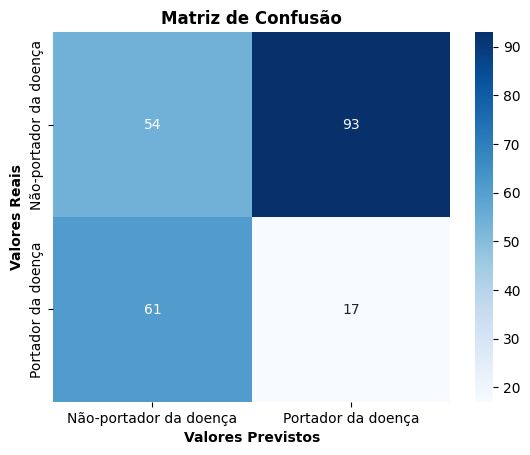


Verdadeiros negativos (VN): 54
Falsos positivos (FP): 93

Falsos negativos (FN): 61
Verdadeiros positivos (VP): 17



In [ ]:
classes = ['Não-portador da doença', 'Portador da doença']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Configurações do gráfico
plt.title('Matriz de Confusão', fontweight='bold')
plt.xlabel('Valores Previstos', fontweight='bold')

plt.ylabel('Valores Reais', fontweight='bold')

# Exibe o gráfico
plt.show()

# Imprime os resultados
print(f"""
Verdadeiros negativos (VN): {verdadeiros_negativos}
Falsos positivos (FP): {falsos_positivos}

Falsos negativos (FN): {falsos_negativos}
Verdadeiros positivos (VP): {verdadeiros_positivos}
""")

# Conclusões


Hiperparâmetros finais utilizados:
- $\eta = 0.1\%$
- $N_b = 200$
- $N_e = 10000$


Rede implementada:
- Acurácia: 100.0 %
- F1-Score = 0.18085106382978725

Rede de Regressão Logística para comparação:
- Acurácia: 100.0 %
- F1-Score: 0.18085106382978725


O modelo implementado para ambos os casos teve um rendimento razoavelmente alto para predição de pacientes não-portadores da doença e bem pequeno para prever casos de pacientes portadores.